# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [108]:
import numpy as np
import pylab as plt
import swyft
import torch
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
DEVICE = 'cuda:0'
NDIM = 2 # number of parameters
NBATCH = 128  # minibatch size
NTRAIN = 3000
NEPOCHS = NTRAIN // (NTRAIN // NBATCH) # training epochs
NSAMPLES = 3000 # traing batch size
NWORKERS = 4 # number of cpu workers for dataloader

In [110]:
# A toy model with a diffuse and point source component

def model(z, sigma = .01):
    T = np.array([[1, 1.], [0, 1.]])
    n = np.random.randn(*z.shape)*sigma
    x = T.dot(z) + n
    return x

In [111]:
z0 = np.ones(2)*0.5
model(z0)

array([1.00228273, 0.5102689 ])

In [112]:
class Data(torch.utils.data.Dataset):
    def __init__(self, xz):
        super().__init__()
        self.xz = xz

    def __len__(self):
        return len(self.xz)

    def __getitem__(self, idx):
        return self.xz[idx]

In [113]:
# Generate training data
z_cpu = swyft.sample_hypercube(NSAMPLES, NDIM)
xz_cpu = swyft.simulate_xz(model, z_cpu)
dataset = Data(xz_cpu)

dataset_train, dataset_valid = torch.utils.data.random_split(dataset, [N_train, N_valid])


xz_loader = torch.utils.data.DataLoader(xz, batch_size=NBATCH, num_workers=NWORKERS, pin_memory=True, drop_last=True)

z_valid_cpu = swyft.sample_hypercube(512, NDIM)
xz_valid_cpu = swyft.simulate_xz(model, z_valid_cpu)

xz_valid = Data(xz_valid_cpu)
xz_valid_loader = torch.utils.data.DataLoader(xz_valid, batch_size=NBATCH, num_workers=NWORKERS, pin_memory=True, drop_last=True)

NameError: name 'N_train' is not defined

In [107]:
# Instantiate network

net = swyft.Network(xdim = NDIM, zdim = NDIM).to(DEVICE)

In [72]:
# Train!

train_loss, valid_loss = [], []
for i, lr in enumerate([1e-3, 1e-4, 1e-5]):
    print(f'LR Iter {i}', end="\r")
    tl, vl, sd = swyft.train(net, xz_loader, xz_valid_loader, early_stopping_patience = 20, lr = lr, max_epochs = 10, device=DEVICE)
    vl_minimum = min(vl)
    vl_min_idx = vl.index(vl_minimum)
    train_loss.append(tl[:vl_min_idx + 1])
    valid_loss.append(vl[:vl_min_idx + 1])
    net.load_state_dict(sd)

In [95]:
# Generate test image for given parameters, estimate posteriors

z0 = np.array([0.1, 0.5])
x0 = model(z0)
print(x0)

x0 = torch.tensor(x0).float().to(DEVICE)
z = torch.stack(swyft.get_z(xz)).to(DEVICE)
post = swyft.estimate_lnL(net, x0, z)

[0.60009722 0.50508375]


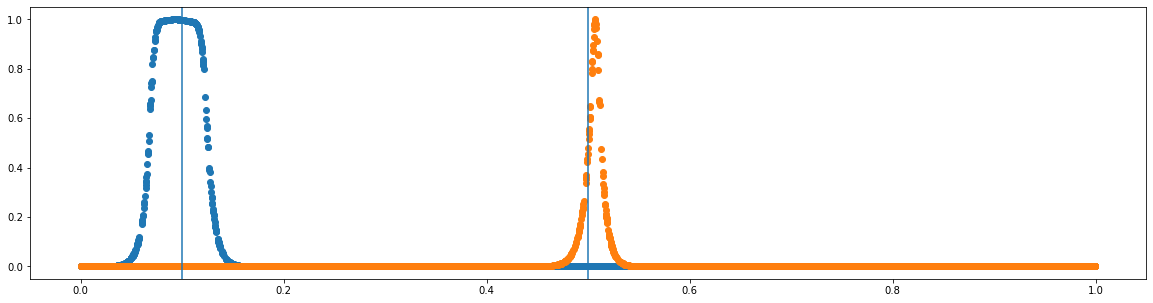

In [96]:
# Likelihood (posteriors because prior was uniform) evaluated on a validation set

plt.figure(figsize=(20, 5))
for i in range(NDIM):
    zp = post[i]['z']
    lnLp = np.exp(post[i]['lnL'])
    plt.axvline(z0[i])
    plt.scatter(zp, lnLp)
#plt.ylim([-10, 0])

In [81]:
# Generate training data
z2_cpu = swyft.iter_sample_z(NSAMPLES, NDIM, net, x0, threshold = 1e-8)
xz2_cpu = swyft.simulate_xz(model, z2_cpu)

xz2 = Data(xz2_cpu)
xz2_loader = torch.utils.data.DataLoader(xz2, batch_size=NBATCH, num_workers=NWORKERS, pin_memory=True, drop_last=True)

z2_valid_cpu = swyft.iter_sample_z(513, NDIM, net, x0, threshold = 1e-8)
xz2_valid_cpu = swyft.simulate_xz(model, z2_valid_cpu)

xz2_valid = Data(xz2_valid_cpu)
xz2_valid_loader = torch.utils.data.DataLoader(xz2_valid, batch_size=NBATCH, num_workers=NWORKERS, pin_memory=True, drop_last=True)

In [82]:
# Instantiate network
net2 = swyft.Network(xdim = NDIM, zdim = NDIM).to(DEVICE)

# Train!
train_loss, valid_loss = [], []
for i, lr in enumerate([1e-3, 1e-4, 1e-5]):
    print(f'LR Iter {i}', end="\r")
    tl, vl, sd = swyft.train(net2, xz2_loader, xz2_valid_loader, early_stopping_patience = 20, lr = lr, device=DEVICE, max_epochs = 20)
    vl_minimum = min(vl)
    vl_min_idx = vl.index(vl_minimum)
    train_loss.append(tl[:vl_min_idx + 1])
    valid_loss.append(vl[:vl_min_idx + 1])
    net.load_state_dict(sd)

(0.0, 1.0)

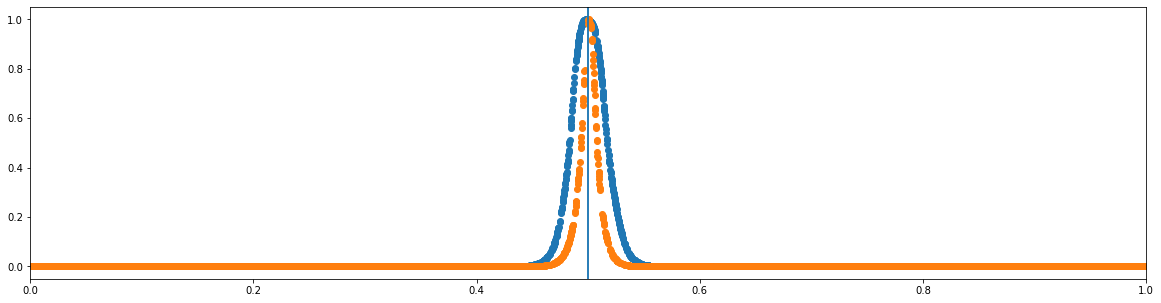

In [83]:
# Likelihood (posteriors because prior was uniform) evaluated on a validation set

z2 = [item.to(DEVICE) for item in swyft.get_z(xz2)]
post2 = swyft.estimate_lnL(net2, x0, z2)

plt.figure(figsize=(20, 5))
for i in range(NDIM):
    zp = post2[i]['z']
    lnLp = np.exp(post2[i]['lnL'])
    plt.axvline(z0[i])
    plt.scatter(zp, lnLp)
plt.xlim([0, 1])

# Combinations using 1st round data

In [88]:
# Instantiate network
combinations = [[0, 1], [0, 1]]
net_combo = swyft.Network(xdim = NDIM, zdim = NDIM, pdim=len(combinations[0])).to(DEVICE)

# Train!
train_loss, valid_loss = [], []
for i, lr in enumerate([1e-3, 1e-4, 1e-5]):
    print(f'LR Iter {i}', end="\r")
    tl, vl, sd = swyft.train(
        net_combo, 
        xz_loader, 
        xz_valid_loader, 
        max_epochs = 5,
        early_stopping_patience = 5, 
        lr = lr, 
        combinations=combinations,
        device=DEVICE
    )
    vl_minimum = min(vl)
    vl_min_idx = vl.index(vl_minimum)
    train_loss.append(tl[:vl_min_idx + 1])
    valid_loss.append(vl[:vl_min_idx + 1])
    net_combo.load_state_dict(sd)

<Figure size 1440x360 with 0 Axes>

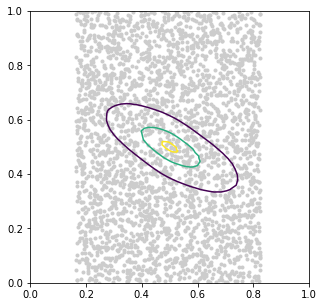

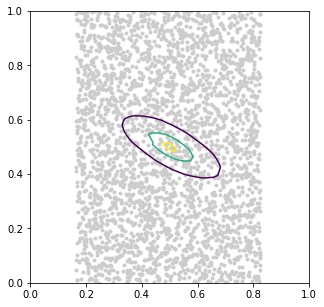

In [91]:
# Log Likelihood (posteriors because prior was uniform) evaluated on a validation set
z_valid = [item.to(DEVICE) for item in swyft.get_z(xz_valid)]
post_valid = swyft.estimate_lnL(net_combo, x0, z2, n_batch=65, combinations=combinations)

plt.figure(figsize=(20, 5))
for i in range(NDIM):
    plt.figure(figsize = (5, 5))
    xx = post_valid[i]['lnL']
    zz = post_valid[i]['z']
    plt.scatter(zz[:, 0], zz[:, 1], marker='.', color='0.8')
    plt.tricontour(zz[:, 0], zz[:, 1], (xx - xx.max())*2, levels = [-9, -4, -1])
    plt.xlim([0, 1])
    plt.ylim([0, 1])